In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [39]:
import json
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
# import sklearn.cluster.hierarchical as hclust
from sklearn import preprocessing
import seaborn as sns

# import data 

In [5]:
DATA_FILE = "/gdrive/MyDrive/Colab Notebooks/ssafy/data/data.json"
DUMP_FILE = "/gdrive/MyDrive/Colab Notebooks/ssafy/data/dump.pkl"

store_columns = (
    "id",  # 음식점 고유번호
    "store_name",  # 음식점 이름
    "branch",  # 음식점 지점 여부
    "area",  # 음식점 위치
    "tel",  # 음식점 번호
    "address",  # 음식점 주소
    "latitude",  # 음식점 위도
    "longitude",  # 음식점 경도
    "category",  # 음식점 카테고리
)

review_columns = (
    "id",  # 리뷰 고유번호
    "store",  # 음식점 고유번호
    "user",  # 유저 고유번호
    "score",  # 평점
    "content",  # 리뷰 내용
    "reg_time",  # 리뷰 등록 시간
)

menu_columns = (
    "id",
    "store",
    "menu_name",
    "price",
)

user_columns = (
    "id",
    "gender",
    "age",
)


def import_data(data_path=DATA_FILE):
    try:
        with open(data_path, encoding="utf-8") as f:
            data = json.loads(f.read())
    except FileNotFoundError as e:
        print(f"`{data_path}` 가 존재하지 않습니다.")
        exit(1)

    stores = []  # 음식점 테이블
    reviews = []  # 리뷰 테이블
    menus = [] # 메뉴 테이블
    users = [] # 유저 테이블
    menu_id = 0

    for d in data:
        categories = [c["category"] for c in d["category_list"]]
        stores.append(
            [
                d["id"],
                d["name"],
                d["branch"],
                d["area"],
                d["tel"],
                d["address"],
                d["latitude"],
                d["longitude"],
                "|".join(categories),
            ]
        )

        for review in d["review_list"]:
            r = review["review_info"]
            u = review["writer_info"]
            user_age = 2021 - int(u["born_year"]) + 1

            reviews.append(
                [r["id"], d["id"], u["id"], r["score"], r["content"], r["reg_time"]]
            )
            users.append(
                [u["id"], u["gender"], user_age]
            )

        for menu in d["menu_list"]:
            menus.append(
                [menu_id, d["id"], menu["menu"], menu["price"]]
            )
            menu_id +=1

    store_frame = pd.DataFrame(data=stores, columns=store_columns)
    review_frame = pd.DataFrame(data=reviews, columns=review_columns)
    memu_frame = pd.DataFrame(data=menus, columns=menu_columns)
    user_frame = pd.DataFrame(data=users, columns=user_columns)

    return {"stores": store_frame, "reviews": review_frame, "menus": memu_frame, "users":user_frame}


def dump_dataframes(dataframes):
    pd.to_pickle(dataframes, DUMP_FILE)


def load_dataframes():
    return pd.read_pickle(DUMP_FILE)


print("[*] Parsing data...")
raw_data = import_data()
print("[+] Done")

print("[*] Dumping data...")
dump_dataframes(raw_data)
print("[+] Done\n")

raw_data = load_dataframes()

[*] Parsing data...
[+] Done
[*] Dumping data...
[+] Done



In [6]:
MUSLIM_PATH = '/gdrive/MyDrive/Colab Notebooks/ssafy/data/무슬림친화레스토랑.csv'
CSV_MUSLIM_PATH = pd.read_csv(MUSLIM_PATH, engine='python', encoding='cp949')
print(CSV_MUSLIM_PATH["주소"].head())

0       서울 용산구 우사단로 34 
1       서울 용산구 우사단로 42 
2     부산 금정구 금단로 123-9 
3        인천 연수구 옥련로 31 
4    경남 창원시 성산구 용지로 74 
Name: 주소, dtype: object


In [7]:
MUSLIM_SEOUL_PATH = '/gdrive/MyDrive/Colab Notebooks/ssafy/data/무슬림서울만.csv'
CSV_MUSLIM_SEOUL = pd.read_csv(MUSLIM_SEOUL_PATH, engine='python', encoding='cp949')
print(CSV_MUSLIM_SEOUL.head())

   idx store_name                            address category
0    0      우스마니아              서울특별시 용산구 이태원동 137-56   파키스탄음식
1    1  미스터케밥 2호점              서울특별시 용산구 이태원동 136-45     터키음식
2    7        미가미     서울특별시 서초구 서초동 1337-32 서초동 광일빌딩       일식
3    8       패밀리아  서울특별시 강남구 논현동 248-7 임피리얼 팰리스호텔 1층      뷔페식
4    9         깔리                 서울특별시 종로구 명륜4가 171     인도음식


In [8]:
MUSLIM_REVIEW_PATH = '/gdrive/MyDrive/Colab Notebooks/ssafy/data/무슬림리뷰만.csv'
CSV_MUSLIM_REVIEW = pd.read_csv(MUSLIM_REVIEW_PATH, engine='python', encoding='cp949')
print(CSV_MUSLIM_REVIEW.head())

  store_name   store
0      우스마니아  308561
1        미가미  155677
2       패밀리아  430186
3         깔리   55195
4      세븐스퀘어  224459


# 전처리

 userID, storeID, rating, title 로 만들기

In [15]:
#skD
raw_store_table = raw_data["stores"].copy()
store_table = raw_store_table[['id', 'store_name','address']]

raw_review_table = raw_data["reviews"].copy()
review_table = raw_review_table[['store','user','score']]

raw_user_table = raw_data["users"].copy()
user_table = raw_user_table[['id','gender','age']]

#muD
raw_muslim_table = CSV_MUSLIM_SEOUL.copy()
muslim_table = raw_muslim_table[["store_name",'address']]
# muslim_table.columns = ['store_name','M_address']
raw_muslim_review = CSV_MUSLIM_REVIEW.copy()

In [17]:
review_table["store"].replace(159620, 159619)
review_table["store"].replace(159622, 159619)

0            15
1            18
2            19
3            37
4            38
          ...  
91393    360499
91394    360505
91395    360514
91396    360514
91397    360515
Name: store, Length: 91398, dtype: int64

In [18]:
musilm_review_table = pd.merge(raw_muslim_review, review_table, on='store', how='left')
print(musilm_review_table.shape)
musilm_review_table.head(20)

(128, 4)


,store_name,store,user,score
0,우스마니아,308561,225842.0,4.0
1,우스마니아,308561,90292.0,4.0
2,미가미,155677,52663.0,5.0
3,패밀리아,430186,NaN,NaN
4,깔리,55195,442382.0,5.0
5,깔리,55195,688218.0,4.0
6,깔리,55195,816257.0,5.0
7,깔리,55195,510431.0,3.0
8,깔리,55195,362703.0,5.0
9,깔리,55195,213564.0,4.0


In [40]:
musilm_store_table.to_csv('/gdrive/MyDrive/Colab Notebooks/ssafy/MyDF2.csv',encoding="utf-8-sig")

In [13]:
store_table.head

,id,store_name
0,1,Agal
1,2,Assisy
2,3,Battered Sole
3,4,Chakyoung
4,5,Delabobo


# 분석

In [83]:
from sklearn.decomposition import TruncatedSVD

user_review_data = userID, storeID, rating, title

In [107]:
user_store_data = musilm_review_table.copy()

In [108]:
min(user_store_data["score"])

1.0

In [113]:
user_store_rating = user_store_data.pivot_table('score',index='user', columns='store_name').fillna(min(user_store_data["score"]))
store_user_rating = user_store_rating.values.T
store_user_rating.shape

(25, 89)

In [138]:
SVD = TruncatedSVD(n_components=3)

In [139]:
matrix = SVD.fit_transform(store_user_rating)
matrix.shape

(25, 3)

In [140]:
corr = np.corrcoef(matrix)
corr.shape

(25, 25)

In [141]:
store_title = user_store_rating.columns
store_title_list = list(store_title)
store_title_list

['그랜드 키친',
 '깔리',
 '델리인디아',
 '델리팰리스',
 '루나아시아',
 '리틀인디아',
 '명동정',
 '모로코코 카페',
 '미가미',
 '미스터케밥',
 '바바인디아',
 '발우공양',
 '사마르칸트',
 '세븐스퀘어',
 '아건 레스토랑',
 '여우골초밥',
 '예티',
 '오샬',
 '오세계향',
 '옷살',
 '우스마니아',
 '이지인디아',
 '전주식당',
 '종로설렁탕',
 '카페 우즈베키스탄']

In [154]:
store_title = user_store_rating.columns
store_title_list = list(store_title)
coffey_hands = store_title_list.index("예티")
print(coffey_hands) #인덱스 값 찾기

16


In [155]:
corr_coffey_hands = corr[coffey_hands]
list(store_title[(corr_coffey_hands >= 0.9)])[:6] # 유사한 식당 10개

['그랜드 키친', '델리인디아', '델리팰리스', '루나아시아', '리틀인디아', '명동정']

Matrix Factorization


https://yamalab.tistory.com/92?category=747907



In [ ]:
import numpy as np


class MatrixFactorization():
    def __init__(self, R, k, learning_rate, reg_param, epochs, verbose=False):
        """
        :param R: rating matrix
        :param k: latent parameter
        :param learning_rate: alpha on weight update
        :param reg_param: beta on weight update
        :param epochs: training epochs
        :param verbose: print status
        """

        self._R = R
        self._num_users, self._num_items = R.shape
        self._k = k
        self._learning_rate = learning_rate
        self._reg_param = reg_param
        self._epochs = epochs
        self._verbose = verbose


    def fit(self):
        """
        training Matrix Factorization : Update matrix latent weight and bias

        참고: self._b에 대한 설명
        - global bias: input R에서 평가가 매겨진 rating의 평균값을 global bias로 사용
        - 정규화 기능. 최종 rating에 음수가 들어가는 것 대신 latent feature에 음수가 포함되도록 해줌.

        :return: training_process
        """

        # init latent features
        self._P = np.random.normal(size=(self._num_users, self._k))
        self._Q = np.random.normal(size=(self._num_items, self._k))

        # init biases
        self._b_P = np.zeros(self._num_users)
        self._b_Q = np.zeros(self._num_items)
        self._b = np.mean(self._R[np.where(self._R != 0)])

        # train while epochs
        self._training_process = []
        for epoch in range(self._epochs):

            # rating이 존재하는 index를 기준으로 training
            for i in range(self._num_users):
                for j in range(self._num_items):
                    if self._R[i, j] > 0:
                        self.gradient_descent(i, j, self._R[i, j])
            cost = self.cost()
            self._training_process.append((epoch, cost))

            # print status
            if self._verbose == True and ((epoch + 1) % 10 == 0):
                print("Iteration: %d ; cost = %.4f" % (epoch + 1, cost))


    def cost(self):
        """
        compute root mean square error
        :return: rmse cost
        """

        # xi, yi: R[xi, yi]는 nonzero인 value를 의미한다.
        # 참고: http://codepractice.tistory.com/90
        xi, yi = self._R.nonzero()
        predicted = self.get_complete_matrix()
        cost = 0
        for x, y in zip(xi, yi):
            cost += pow(self._R[x, y] - predicted[x, y], 2)
        return np.sqrt(cost) / len(xi)


    def gradient(self, error, i, j):
        """
        gradient of latent feature for GD

        :param error: rating - prediction error
        :param i: user index
        :param j: item index
        :return: gradient of latent feature tuple
        """

        dp = (error * self._Q[j, :]) - (self._reg_param * self._P[i, :])
        dq = (error * self._P[i, :]) - (self._reg_param * self._Q[j, :])
        return dp, dq


    def gradient_descent(self, i, j, rating):
        """
        graident descent function

        :param i: user index of matrix
        :param j: item index of matrix
        :param rating: rating of (i,j)
        """

        # get error
        prediction = self.get_prediction(i, j)
        error = rating - prediction

        # update biases
        self._b_P[i] += self._learning_rate * (error - self._reg_param * self._b_P[i])
        self._b_Q[j] += self._learning_rate * (error - self._reg_param * self._b_Q[j])

        # update latent feature
        dp, dq = self.gradient(error, i, j)
        self._P[i, :] += self._learning_rate * dp
        self._Q[j, :] += self._learning_rate * dq


    def get_prediction(self, i, j):
        """
        get predicted rating: user_i, item_j
        :return: prediction of r_ij
        """
        return self._b + self._b_P[i] + self._b_Q[j] + self._P[i, :].dot(self._Q[j, :].T)


    def get_complete_matrix(self):
        """
        computer complete matrix PXQ + P.bias + Q.bias + global bias

        - PXQ 행렬에 b_P[:, np.newaxis]를 더하는 것은 각 열마다 bias를 더해주는 것
        - b_Q[np.newaxis:, ]를 더하는 것은 각 행마다 bias를 더해주는 것
        - b를 더하는 것은 각 element마다 bias를 더해주는 것

        - newaxis: 차원을 추가해줌. 1차원인 Latent들로 2차원의 R에 행/열 단위 연산을 해주기위해 차원을 추가하는 것.

        :return: complete matrix R^
        """
        return self._b + self._b_P[:, np.newaxis] + self._b_Q[np.newaxis:, ] + self._P.dot(self._Q.T)


    def print_results(self):
        """
        print fit results
        """

        print("User Latent P:")
        print(self._P)
        print("Item Latent Q:")
        print(self._Q.T)
        print("P x Q:")
        print(self._P.dot(self._Q.T))
        print("bias:")
        print(self._b)
        print("User Latent bias:")
        print(self._b_P)
        print("Item Latent bias:")
        print(self._b_Q)
        print("Final R matrix:")
        print(self.get_complete_matrix())
        print("Final RMSE:")
        print(self._training_process[self._epochs-1][1])


# run example
if __name__ == "__main__":
    # rating matrix - User X Item : (7 X 5)
    R = np.array([
        [1, 0, 0, 1, 3],
        [2, 0, 3, 1, 1],
        [1, 2, 0, 5, 0],
        [1, 0, 0, 4, 4],
        [2, 1, 5, 4, 0],
        [5, 1, 5, 4, 0],
        [0, 0, 0, 1, 0],
    ])

    # P, Q is (7 X k), (k X 5) matrix
    factorizer = MatrixFactorization(R, k=3, learning_rate=0.01, reg_param=0.01, epochs=300, verbose=True)
    factorizer.fit()
    factorizer.print_results()

Iteration: 10 ; cost = 0.2490
Iteration: 20 ; cost = 0.1810
Iteration: 30 ; cost = 0.1478
Iteration: 40 ; cost = 0.1245
Iteration: 50 ; cost = 0.1040
Iteration: 60 ; cost = 0.0850
Iteration: 70 ; cost = 0.0685
Iteration: 80 ; cost = 0.0552
Iteration: 90 ; cost = 0.0452
Iteration: 100 ; cost = 0.0378
Iteration: 110 ; cost = 0.0324
Iteration: 120 ; cost = 0.0282
Iteration: 130 ; cost = 0.0249
Iteration: 140 ; cost = 0.0222
Iteration: 150 ; cost = 0.0200
Iteration: 160 ; cost = 0.0180
Iteration: 170 ; cost = 0.0164
Iteration: 180 ; cost = 0.0149
Iteration: 190 ; cost = 0.0136
Iteration: 200 ; cost = 0.0125
Iteration: 210 ; cost = 0.0115
Iteration: 220 ; cost = 0.0106
Iteration: 230 ; cost = 0.0098
Iteration: 240 ; cost = 0.0091
Iteration: 250 ; cost = 0.0085
Iteration: 260 ; cost = 0.0080
Iteration: 270 ; cost = 0.0075
Iteration: 280 ; cost = 0.0070
Iteration: 290 ; cost = 0.0066
Iteration: 300 ; cost = 0.0063
User Latent P:
[[ 0.5618006   0.57537486  0.63126051]
 [-0.91539844 -0.09032298

# clustering

In [19]:
# user data만 뽑고 중복 제거해서 유저 데이터 모음
musilm_user = musilm_review_table["user"]
musilm_user.drop_duplicates(inplace=True)
musilm_user.dropna(inplace=True)

In [20]:
musilm_user.shape

(89,)

In [54]:
# user 데이터와 merge 해서 데이터 추출
musilm_review_user = pd.merge(musilm_user, user_table, left_on='user', right_on='id', how='inner')
musilm_review_user.drop_duplicates(inplace=True)
print(musilm_review_user.shape)
musilm_review_user.reset_index(drop=True, inplace=True)
musilm_review_user.head()

(89, 4)


,user,id,gender,age
0,225842.0,225842,여,23
1,90292.0,90292,여,26
2,52663.0,52663,여,29
3,442382.0,442382,여,27
4,688218.0,688218,여,29


In [55]:
#나이만 추출
musilm_only_user = musilm_review_user[["user","age"]]
#정규화
scaler = preprocessing.MinMaxScaler()
features_normal = scaler.fit_transform(musilm_only_user)
musilm_only_user_normal= pd.DataFrame(features_normal ,columns=['nor_user', 'nor_age',])

musilm_review_nor_user = pd.concat([musilm_review_user, musilm_only_user_normal], axis=1)
musilm_review_nor_user.head()

,user,id,gender,age,nor_user,nor_age
0,225842.0,225842,여,23,0.238406,0.000000
1,90292.0,90292,여,26,0.095210,0.076923
2,52663.0,52663,여,29,0.055458,0.153846
3,442382.0,442382,여,27,0.467161,0.102564
4,688218.0,688218,여,29,0.726864,0.153846


In [58]:
musilm_review_nor_user["gender_m"] = musilm_review_nor_user["gender"].apply(lambda x: 1 if x=='남' else 0 )
musilm_review_nor_user["gender_f"] = musilm_review_nor_user["gender"].apply(lambda x: 1 if x=='여' else 0 )

In [59]:
musilm_review_nor_user.head()

,user,id,gender,age,nor_user,nor_age,gender_m,gender_f
0,225842.0,225842,여,23,0.238406,0.000000,0,1
1,90292.0,90292,여,26,0.095210,0.076923,0,1
2,52663.0,52663,여,29,0.055458,0.153846,0,1
3,442382.0,442382,여,27,0.467161,0.102564,0,1
4,688218.0,688218,여,29,0.726864,0.153846,0,1


In [60]:
df_review_user = musilm_review_nor_user[["id","gender_m","gender_f"]]
df_review_user.head()

,id,gender_m,gender_f
0,225842,0,1
1,90292,0,1
2,52663,0,1
3,442382,0,1
4,688218,0,1


k-means

In [61]:
inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_review_user)
    kmeanModel.fit(df_review_user)
    inertia.append(kmeanModel.inertia_)

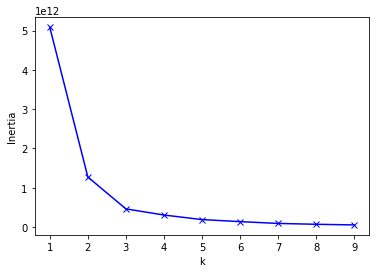

In [62]:
# Plot the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [64]:
kmeans = KMeans(n_clusters=3).fit(features_normal)

In [65]:
labels = pd.DataFrame(kmeans.labels_)
labeledColleges = pd.concat((musilm_review_user,labels),axis=1)
labeledColleges = labeledColleges.rename({0:'labels'},axis=1)

In [66]:
labeledColleges.head()

,user,id,gender,age,gender_m,gender_f,labels
0,225842.0,225842,여,23,0,1,1
1,90292.0,90292,여,26,0,1,1
2,52663.0,52663,여,29,0,1,1
3,442382.0,442382,여,27,0,1,1
4,688218.0,688218,여,29,0,1,2


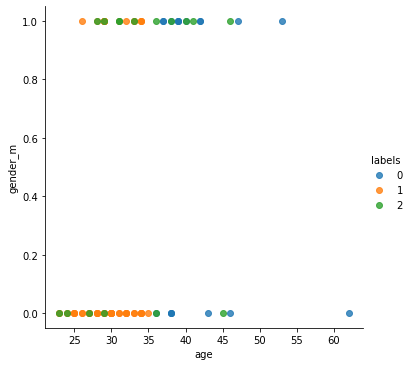

In [68]:
sns.lmplot(x='age',y='gender_m',data=labeledColleges,hue='labels',fit_reg=False)